In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

/home/prabakaran/Téléchargements/Stage-04_2025/Stage-04_2025/GuacaMoliency/molgpt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("../models/trained_moses_ClearSMILES_BEP/1/final_model")
model = AutoModelForCausalLM.from_pretrained("../models/trained_moses_ClearSMILES_BEP/1/final_model")

In [3]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(10000, 256)
    (wpe): Embedding(60, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=10000, bias=False)
)

In [4]:
with torch.no_grad():
        # generation 
        generated_ids = model.generate(
        max_length = tokenizer.model_max_length,
        num_return_sequences = 1000,
        pad_token_id = tokenizer.pad_token_id,
        bos_token_id = tokenizer.bos_token_id,
        eos_token_id = tokenizer.eos_token_id,
        do_sample = True,
        temperature = 1,
        return_dict_in_generate = True,
    ) 
        
        generated_smiles = [tokenizer.decode(output, skip_special_tokens=True).replace(" ","") for output in generated_ids['sequences']]


In [5]:
generated_ids.sequences

tensor([[   0,  345,  478,  ...,    2,    2,    2],
        [   0,   85, 5852,  ...,    2,    2,    2],
        [   0,  515, 1127,  ...,    2,    2,    2],
        ...,
        [   0,  744,  467,  ...,    2,    2,    2],
        [   0,  739,  946,  ...,    2,    2,    2],
        [   0,  179, 2471,  ...,    2,    2,    2]])

In [6]:
len_mean = 0
for k in generated_ids["sequences"]:
    len_mean += len(k)
len_mean /= len(generated_ids.sequences)

In [7]:
len_mean

14.0

In [8]:
vocab_usage = len(tokenizer) * [0]
vocab_ids = [i for i in range(10000)]
for i in tqdm(range(300)): 
    with torch.no_grad():
        # generation 
        generated_ids = model.generate(
        max_length = tokenizer.model_max_length,
        num_return_sequences = 1000,
        pad_token_id = tokenizer.pad_token_id,
        bos_token_id = tokenizer.bos_token_id,
        eos_token_id = tokenizer.eos_token_id,
        do_sample = True,
        temperature = 1,
        return_dict_in_generate = True,
    ) 
        for k in generated_ids.sequences:
            for l in k:
                if l>2:
                    vocab_usage[l] += 1



  0%|          | 1/300 [00:07<36:06,  7.24s/it]


KeyboardInterrupt: 

In [97]:
vocab_ids = [vocab_ids[k] for k in range(len(vocab_usage)) if vocab_usage[k] > 1000]
vocab_usage= [k for k in vocab_usage if k> 1000]

In [ ]:
vocab_ids = np.array(vocab_ids)
vocab_usage = np.array(vocab_usage)

In [200]:
# Get indices of top 100 values
top_indices = np.argsort(vocab_usage)[-10:][::-1]  # Sort and take top 100, reverse for descending
top100 = vocab_usage[top_indices]
top100_ids = vocab_ids[top_indices]


In [239]:
label = tokenizer.decode(vocab_ids).split(" ")
label_conserved = [k if k in tokenizer.decode(top100_ids).split(" ") else "" for k in label ]

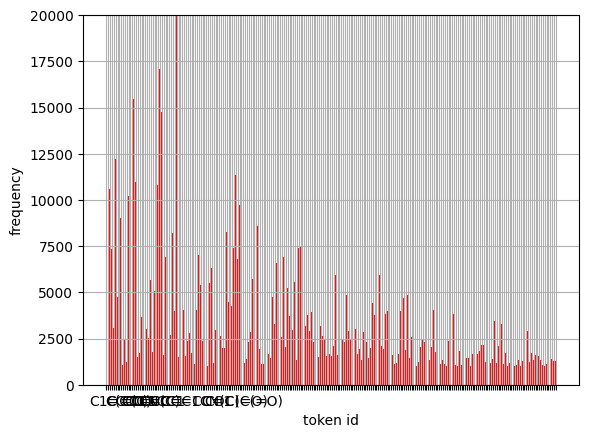

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("token id")
plt.ylabel("frequency")

plt.bar(label,vocab_usage,tick_label=label_conserved,fc="r")

plt.ylim([0,20000])
plt.grid()


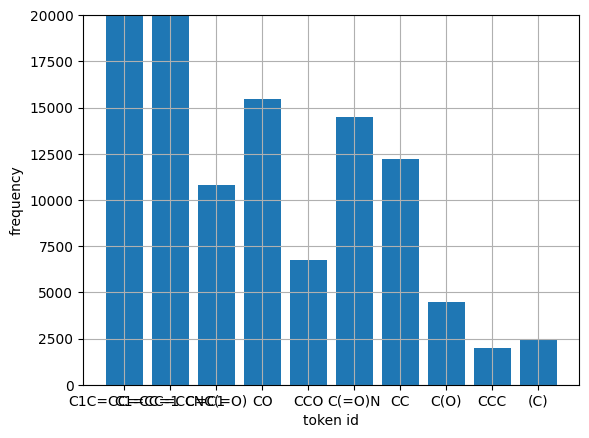

In [114]:
plt.xlabel("token id")
plt.ylabel("frequency")

plt.bar(tokenizer.decode(top100_ids).split(" "),top100)
plt.ylim([0,20000])
plt.grid()


In [240]:
moses_clearsmiles = pd.read_csv("../data/training_data/moses_ClearSMILES.csv")

In [137]:
from random import sample
moses_clearsmiles = moses_clearsmiles["SMILES"].sample(300000, random_state=42)

In [241]:
moses_clearsmiles = moses_clearsmiles["SMILES"]

In [158]:
moses_clearsmiles = moses_clearsmiles.to_list()


In [242]:
vocab_ids_2 = [i for i in range(10000)]
vocab_counts_2 = [0 for i in range(10000)]

for k in tqdm(moses_clearsmiles):
    tokens = tokenizer.encode(k)
    for l in tokens: 
        if l>2:
            vocab_counts_2[l] += 1

100%|██████████| 1755842/1755842 [01:28<00:00, 19891.94it/s]


In [193]:
vocab_ids_2 = [vocab_ids_2[k] for k in range(len(vocab_counts_2)) if vocab_counts_2[k] > 1863]
vocab_counts_2= [k for k in vocab_counts_2 if k> 1863]

In [194]:
vocab_ids_2 = np.array(vocab_ids_2)
vocab_counts_2 = np.array(vocab_counts_2)

In [195]:
from scipy import stats

In [196]:
np.median(vocab_counts_2)

3285.5

In [197]:
stats.describe(vocab_counts_2)

DescribeResult(nobs=740, minmax=(1869, 65998), mean=5456.114864864865, variance=40451273.679616354, skewness=4.476488000156663, kurtosis=28.130120330673844)

In [162]:
len(vocab_counts_2)

1482

In [199]:




# Get indices of top 100 values
top_indices = np.argsort(vocab_counts_2)[-10:][::-1]  # Sort and take top 100, reverse for descending
top100_2 = vocab_counts_2[top_indices]
top100_ids_2 = vocab_ids_2[top_indices]

In [181]:
len(set(top100_ids))

100

In [201]:
counter = 0
for k in top100_ids:
    if k in top100_ids_2:
        counter += 1
print(counter/len(top100_ids))

0.6


In [198]:
counter = 0
for k in vocab_ids:
    if k in vocab_ids_2:
        counter += 1
print(counter/len(vocab_ids))

0.9795081967213115


In [243]:
label2 = tokenizer.decode(vocab_ids_2).split(" ")
label_conserved_2 = [k if k in tokenizer.decode(top100_ids_2).split(" ") else "" for k in label2 ]

In [295]:
vocab_usage_normalized = []
vocab_counts_2_normalized = []
for k in range(len(vocab_usage)):
    vocab_usage_normalized.append(np.exp(vocab_usage[k]/1000))
for k in range(len(vocab_counts_2)):
    vocab_counts_2_normalized.append(np.exp(vocab_counts_2[k]/1000))




In [296]:
a = sum(vocab_counts_2_normalized)
b = sum(vocab_usage_normalized)

In [297]:
vocab_counts_2_normalized = [np.log(k/a +1) for k in vocab_counts_2_normalized]
vocab_usage_normalized = [np.log(k/b+1) for k in vocab_usage_normalized]

In [299]:
vocab_counts_2_normalized

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.2434497875801676e-14,
 0.0,
 0.0,
 0.0,
 1.602495913742667e-12,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.8821588730238526e-10,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.661338147750937e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.081335104243121e-11,
 0.0,
 0.0,
 3.3839597790569046e-13,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.9984014443252798e-15,
 0.0,
 0.6253946471932883,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.

In [300]:
max(vocab_counts_2_normalized)

0.6253946471932883

In [301]:
max(vocab_usage_normalized)

0.4952049020993617

(0.0, 0.6253946471932883)

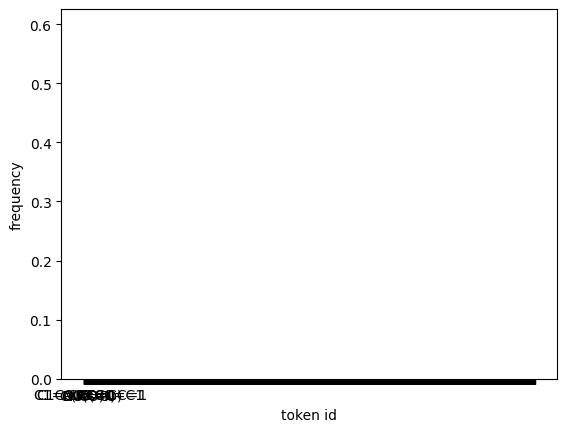

In [302]:

plt.xlabel("token id")
plt.ylabel("frequency")

plt.bar(label,vocab_usage_normalized,fc="r")
plt.bar(label2,vocab_counts_2_normalized,tick_label=label_conserved_2,fc="b")

plt.ylim([0,max(vocab_counts_2_normalized)])

